<a href="https://colab.research.google.com/github/Knightrobber/Image-Inpainting-GAN/blob/main/inpaintingSub.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [21]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
from torchvision import transforms
from torch.utils import data

# Data

In [22]:
#splitting the datasets here
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform) # 10 classes of images. total 50000 images of 32*32, 6000 images per class.airplane ,automobile,bird,cat,deer,dog,frog,horse,ship,truck
#test = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified


In [23]:
print( (dataset[1][0]).shape )

train_split, val_split, test_split = 0.9, 0.05, 0.05
train_size = int(len(dataset) * train_split)
val_size = int(len(dataset) * val_split)
test_size = int(len(dataset) * test_split)

train, val, test = data.random_split(dataset, (train_size, val_size, test_size))
print(len(train), len(val), len(test))
print( train[0][0][0][0][0] ) 

torch.Size([3, 32, 32])
45000 2500 2500
tensor(0.3882)


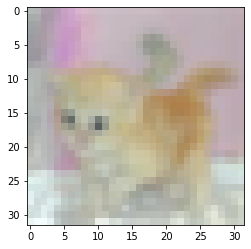

In [24]:
def imshow(tensor):
    """if len(tensor.shape) == 4:
        tensor = tensor[0]"""
    plt.imshow(tensor.permute(1, 2, 0))

imshow(train[1000][0])

# Masks

In [25]:
def create_hole_mask(im_h, im_w, hole_h, hole_w):
    i = int((im_h - hole_h + 1) * np.random.random())
    j = int((im_w - hole_w + 1) * np.random.random())
    mask = torch.zeros((1, im_h, im_w))
    mask[0, i : i + hole_h, j : j + hole_w] = 1 # 1 for white , 0 for black
    return mask, (i, i + hole_h, j, j + hole_w)

def create_hole_masks(N, im_h, im_w, hole_h, hole_w, same_size=True):
    if same_size:
        masks = [create_hole_mask(im_h, im_w, hole_h, hole_w) for _ in range(N)]
    else:
        h_min, h_max = hole_h
        w_min, w_max = hole_w
        hs, ws = np.random.randint(h_min, h_max, N), np.random.randint(w_min, w_max, N)
        masks = [create_hole_mask(im_h, im_w, h, w) for h, w in zip(hs, ws)]

    bounds = [mask[1] for mask in masks] # bounds of all masks here
    masks = [mask[0] for mask in masks]# the masks are stored here
    masks = torch.cat(masks, dim=0) # each mask is 1X32X32 img. Its concatenated along rows 
    return masks.unsqueeze(1), bounds # Returns a new tensor with a dimension of size one inserted at the specified position.




In [26]:
create_hole_masks(2, 3, 3, 1, 1)

(tensor([[[[0., 0., 0.],
           [1., 0., 0.],
           [0., 0., 0.]]],
 
 
         [[[0., 0., 0.],
           [1., 0., 0.],
           [0., 0., 0.]]]]), [(1, 2, 0, 1), (1, 2, 0, 1)])

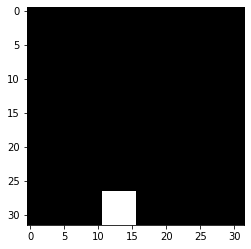

In [27]:
plt.imshow(create_hole_mask(32, 32, 5, 5)[0][0], cmap='gray')

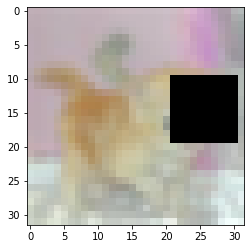

In [28]:
imshow((1 - create_hole_mask(32, 32, 10, 10)[0][0]) * train[1000][0])

# GAN

## Generator

In [29]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.shape[0], -1)

class Unflatten(nn.Module):
    
    def __init__(self, shape):
        super(Unflatten, self).__init__()
        self.shape = shape
    
    def forward(self, X):
        return X.view(-1, *self.shape)

class Generator(nn.Module): # the generator network. we use leaky relu as activation and batch normalisation
    
    def __init__(self, im_channels):
        super(Generator, self).__init__()
        
        
        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            
            
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, 3, stride=1, padding=2, dilation=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=4, dilation=4),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=8, dilation=8),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=16, dilation=16),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            
            nn.ConvTranspose2d(256, 128, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, im_channels, 3, stride=1, padding=1)
            
        )

    def forward(self, X):
        out = self.net(X)
        return out
    
# g = Generator(2)
# g.eval()
# g(train[0][0].unsqueeze(0)).shape

## Local Discriminator

In [30]:
class LocalDiscriminator(nn.Module):
    def __init__(self, im_channels, region_size=16):
        super(LocalDiscriminator, self).__init__()
        
        self.region_size = region_size
        
        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024), # perfomrs linear transformation. if input is [1,512] we get out[1,1024]
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )
        
    def forward(self, X, mask_bounds): # performs the forward propagation on the local regions. The output is a [1,1024] array
        
        local_regions = self._get_local_regions(X, mask_bounds)
        out = self.net(local_regions)
        
        return out
    
    def _get_local_regions(self, X, mask_bounds): # gets the local regions i..e the missing parts or masked part of the image. does it for the entire batch at once

        N, ch, im_h, im_w = X.shape
        local_regions = torch.zeros((N, ch, self.region_size, self.region_size)).cuda()

        for i, bounds in enumerate(mask_bounds):
            y1, y2, x1, x2 = bounds
            
            ym, xm = (y1 + y2) // 2, (x1 + x2) // 2
            y1, x1 = ym - self.region_size // 2, xm - self.region_size // 2
            y2, x2 = y1 + self.region_size, x1 + self.region_size
            
            if y1 < 0:
                y1, y2 = 0, self.region_size
            elif y2 > im_h:
                y1, y2 = im_h - self.region_size, im_h
                
            if x1 < 0:
                x1, x2 = 0, self.region_size
            elif x2 > im_w:
                x1, x2 = im_w - self.region_size, im_w
            
            local_regions[i, :, :, :] = X[i, :, y1 : y2, x1 : x2]
        
        return local_regions

## Global Discriminator

In [33]:
class GlobalDiscriminator(nn.Module): # global discrminator network
    def __init__(self, im_channels):
        super(GlobalDiscriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Conv2d(im_channels + 1, 64, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 128, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 256, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.Conv2d(512, 512, 5, stride=2, padding=2),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
#             nn.Conv2d(512, 512, 5, stride=2, padding=2),
#             nn.LeakyReLU(0.1),
#             nn.BatchNorm2d(512),
            Flatten(),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(1024)
        )
        
    def forward(self, X): # performs forward propagation on the entire image and produces a [1,1024] output
        out = self.net(X)
        return out
        
        

## Complete Discriminator

In [35]:
class Discriminator(nn.Module): # the complete discriminator with local and global discriminators.
    def __init__(self, local_d, global_d):
        super(Discriminator, self).__init__()
        self.local_discriminator = local_d
        self.global_discriminator = global_d
        self.fc = nn.Linear(2048, 1)  # here both outputs from the local and global discriminator are combined and a linear transformation is applied
        
    def forward(self, X, mask_bounds):
        local_ = self.local_discriminator(X, mask_bounds)
        global_ = self.global_discriminator(X)
        concated = torch.cat((local_, global_), dim=1)
        out = self.fc(concated)
        
        return out


# Train GAN

In [36]:
import time

def cycle(iterable):
    while True:
        for x in iterable:
            yield x

def train_gan(g, d, train, val, g_o, d_o, params, masks_fn):

    train_loader = data.DataLoader(train, batch_size=params['batch_size'], num_workers=0, pin_memory=True) # returns an iterable over the train data
    val_loader = data.DataLoader(val, params['val_batch_size'], shuffle=True, pin_memory=True)# returns an iterable over the validation data
    val_loader = iter(cycle(val_loader))
    
    optimizer_g = g_o # optimiser for generator
    optimizer_d = d_o # optimiser for discriminator
    
    T_c, T_d = params['T_c'], params['T_d']
    w = params['w']
    for epoch in range(params['epochs']):
        ep_loss_g = 0. # current epoch loss of generator
        ep_loss_d = 0. # current epoch loss of discriminator
        fake_err = 0. # current loss for a fake image
        real_err = 0. # current loss for real image
        
        if epoch < T_c and epoch == 0:
                print(f'\n>>>> Training generator for {T_c} epochs.')

        if epoch < T_c + T_d and epoch == T_c:
                print(f'\n>>>> Training discriminator for {T_d} epochs.')
                
        if epoch == T_c + T_d:
                print(f'\n>>>> Training both generator and discriminator jointly.')
        
        start_time = time.time()
        
        g.train()
        d.train()
        for batch, _ in train_loader:
            
            N = batch.shape[0]
            batch = batch.cuda()
            
            masks_g, bounds_g = masks_fn(N) 
            batch_masked = batch.clone() * (1 - masks_g) # masking the batch of images 
            batch_with_masks = torch.cat((batch_masked, masks_g[:, :1]), dim=1) # concatenating all images of the batch
            
            fake = g(batch_with_masks)  # the generator generates fake images here
            
            loss_mse = (((batch - fake) * masks_g)**2).sum() / masks_g.sum() # we find the mean squared loss between the generated image and the real image
            
            if epoch < T_c: # only training the generator. backward propagating the errors of the generator
                loss_g = loss_mse
                loss_g.backward() # backward() is called for the last output of the network i..e the loss. It gives the drivative w.r.t loss function
                optimizer_g.step()
                optimizer_g.zero_grad()
                ep_loss_g += loss_g.detach().cpu()
                continue
            else:
                inpainted = batch.clone() # creating the clone of the current batch
                masks_byte = masks_g.byte() # converting the masks to 8 bit images
                inpainted[masks_byte] = fake.detach()[masks_byte].view(-1)
                inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                d_fake = d(inpainted.detach(), bounds_g) # making discriminator predictions for fake images
                
                masks_d, bounds_d = masks_fn(N)
                real = torch.cat((batch.clone(), masks_d[:, :1]), dim=1)
                d_real = d(real, bounds_d) # making discriminator predicitions for real images
                
                loss_d_fake = (d_fake**2).mean() # d_fake is the predicted value for a fake image. the error is squared. If d_fake is close to 1, the error is high
                loss_d_real = ((d_real - 1)**2).mean() # d_real is the predicted value for a real image. If d_real is close to 2 the error is high
                loss_d = (loss_d_fake + loss_d_real) / 2 # we take the average of both losses
                loss_d.backward() # backward propagating the discriminator loss
                optimizer_d.step() # perfoms the parameter update
                optimizer_d.zero_grad() # called right after step as backward accumulates the gradient

                if epoch >= T_c + T_d: # backpropagating the generator using the error at the discriminator
                    inpainted = batch.clone()
                    inpainted[masks_byte] = fake[masks_byte].view(-1)
                    inpainted = torch.cat((inpainted, masks_g[:, :1]), dim=1)
                    d_fake = d(inpainted, bounds_g)
                    loss_g = loss_mse + w * ((d_fake - 1)**2).mean() # the closer the d_fake is to 1, the better the generator

                    loss_g.backward()
                    optimizer_g.step()
                    optimizer_g.zero_grad()

                    ep_loss_g += loss_g.detach().cpu()
                    
                ep_loss_d += loss_d.detach().cpu()
                fake_err += loss_d_fake.detach().cpu()
                real_err += loss_d_real.detach().cpu()
#             break
        
        if not T_c <= epoch < T_c + T_d:
            g.eval()
            val_batch = next(val_loader)[0].cuda()
            N, ch, _, _ = val_batch.shape
            
            masks, _ = masks_fn(N)
            val_batch_masked = val_batch * (1 - masks)
            val_batch_masked = torch.cat((val_batch_masked, masks[:, :1]), dim=1) # holds the validation images with their masks on
            val_pred = g(val_batch_masked).detach() # generating images
            val_loss = (((val_batch - val_pred) * masks)**2).sum() / masks.sum() # loss of the generated image
            inpainted = val_batch.clone()
            masks_byte = masks.byte()
            inpainted[masks_byte] = val_pred[masks_byte]
            imgs = [
                val_batch[0].cpu(), 
                masks[0].cpu(), 
                val_batch_masked[:, :-1][0].cpu(), 
                val_pred[0].cpu().clamp(0, 1), 
                inpainted[0].cpu()
            ]
            imshow(torch.cat(imgs, dim=2)) # displaying the impainted validation img
            plt.axis('off')
            plt.show()

        print('epoch: %d, g_loss: %0.4f, val_loss: %0.4f, d_loss: %0.4f, fake_err: %0.4f, real_err: %0.4f, time: %0.2f' %\
              (epoch, ep_loss_g, val_loss, ep_loss_d, fake_err, real_err, time.time() - start_time))

In [37]:
global_d = GlobalDiscriminator(im_channels=3).cuda()
local_d = LocalDiscriminator(im_channels=3, region_size=16).cuda()
discriminator = Discriminator(local_d=local_d, global_d=global_d).cuda()

generator = Generator(im_channels=3).cuda()



>>>> Training both generator and discriminator jointly.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:61: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:106: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at  /pytorch/aten/src/ATen/native/IndexingUtils.h:30.)


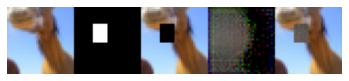

epoch: 0, g_loss: 5.5214, val_loss: 0.0596, d_loss: 36.9577, fake_err: 7.6678, real_err: 66.2475, time: 481.66


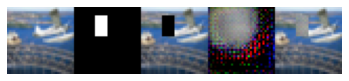

epoch: 1, g_loss: 1.9585, val_loss: 0.0312, d_loss: 31.9693, fake_err: 3.3033, real_err: 60.6354, time: 481.86


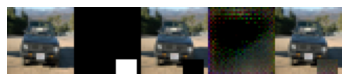

epoch: 2, g_loss: 1.6147, val_loss: 0.0259, d_loss: 30.2066, fake_err: 2.2638, real_err: 58.1495, time: 481.55


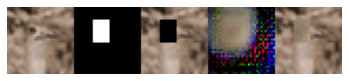

epoch: 3, g_loss: 1.4369, val_loss: 0.0227, d_loss: 28.9487, fake_err: 1.7440, real_err: 56.1533, time: 482.11


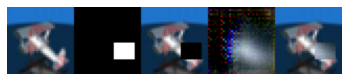

epoch: 4, g_loss: 1.3370, val_loss: 0.0218, d_loss: 27.9109, fake_err: 1.4138, real_err: 54.4080, time: 482.17


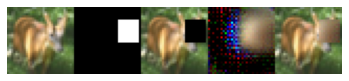

epoch: 5, g_loss: 1.2710, val_loss: 0.0224, d_loss: 26.9996, fake_err: 1.2231, real_err: 52.7761, time: 482.59


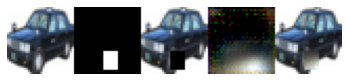

epoch: 6, g_loss: 1.2318, val_loss: 0.0219, d_loss: 26.1483, fake_err: 1.1035, real_err: 51.1932, time: 483.23


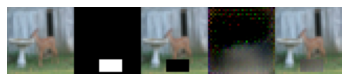

epoch: 7, g_loss: 1.1885, val_loss: 0.0194, d_loss: 25.3811, fake_err: 1.0763, real_err: 49.6858, time: 483.23


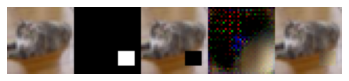

epoch: 8, g_loss: 1.1666, val_loss: 0.0194, d_loss: 24.6390, fake_err: 1.0939, real_err: 48.1841, time: 482.21


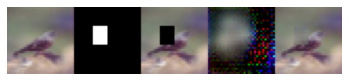

epoch: 9, g_loss: 1.1400, val_loss: 0.0187, d_loss: 23.9280, fake_err: 1.1592, real_err: 46.6968, time: 482.94


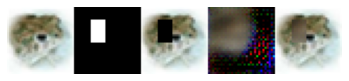

epoch: 10, g_loss: 1.1299, val_loss: 0.0193, d_loss: 23.2400, fake_err: 1.2601, real_err: 45.2200, time: 482.60


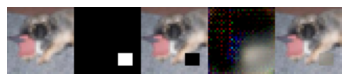

epoch: 11, g_loss: 1.1021, val_loss: 0.0216, d_loss: 22.5626, fake_err: 1.4057, real_err: 43.7195, time: 482.75


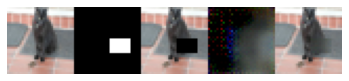

epoch: 12, g_loss: 1.0751, val_loss: 0.0184, d_loss: 21.9097, fake_err: 1.5909, real_err: 42.2285, time: 482.70


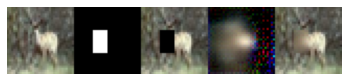

epoch: 13, g_loss: 1.0677, val_loss: 0.0184, d_loss: 21.2653, fake_err: 1.8111, real_err: 40.7195, time: 482.37


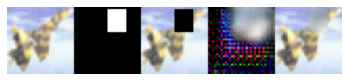

epoch: 14, g_loss: 1.0439, val_loss: 0.0190, d_loss: 20.6410, fake_err: 2.0786, real_err: 39.2034, time: 482.47


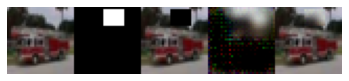

epoch: 15, g_loss: 1.0360, val_loss: 0.0186, d_loss: 20.0363, fake_err: 2.3817, real_err: 37.6910, time: 482.87


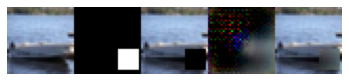

epoch: 16, g_loss: 1.0346, val_loss: 0.0180, d_loss: 19.4615, fake_err: 2.7312, real_err: 36.1918, time: 482.10


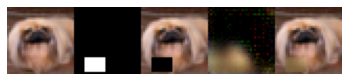

epoch: 17, g_loss: 1.0313, val_loss: 0.0162, d_loss: 18.9059, fake_err: 3.1137, real_err: 34.6981, time: 482.32


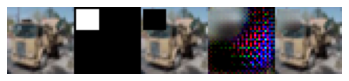

epoch: 18, g_loss: 1.0150, val_loss: 0.0168, d_loss: 18.3753, fake_err: 3.5267, real_err: 33.2239, time: 483.20


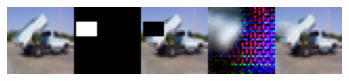

epoch: 19, g_loss: 0.9908, val_loss: 0.0175, d_loss: 17.8840, fake_err: 3.9810, real_err: 31.7869, time: 482.68


In [38]:
train_params = {}
train_params['w'] = 0.0005
train_params['learning_rate_g'] = 0.0001
train_params['learning_rate_d'] = 0.00001
train_params['batch_size'] = 800
train_params['val_batch_size'] = 1024
train_params['T_c'] = 0
train_params['T_d'] = 0
train_params['epochs'] = 20 + train_params['T_c'] + train_params['T_d']

def gen_masks(N, ch=3):
    masks, bounds = create_hole_masks(N, 32, 32, (5, 12), (5, 12), same_size=False)
    return masks.repeat_interleave(ch, dim=1).cuda(), bounds # repeats the matrix of masks 3 times as we need a 3 channel image of the masks to combine with another 3 channel image

optimizer_g = optim.Adam(generator.parameters(), lr=train_params['learning_rate_g'])
optimizer_d = optim.Adam(discriminator.parameters(), lr=train_params['learning_rate_d'])

torch.cuda.empty_cache()
train_gan(generator, discriminator, train, val, optimizer_g, optimizer_d, train_params, gen_masks)

# Evaluation

In [39]:
loss = 0
pixels = 0

In [40]:
model = generator
model.eval()
N = 512
test_loader = iter(data.DataLoader(test, N, shuffle=True, pin_memory=False))

for batch, _ in test_loader:
    masks, _ = gen_masks(batch.shape[0])
    batch_masked = batch.clone().cuda() * (1 - masks)
    batch_masked = torch.cat((batch_masked, masks[:, :1]), dim=1)
    pred = model(batch_masked).clamp(0, 1).detach()


    loss += (((batch.cuda() - pred) * masks)**2).sum().detach().cpu()
    pixels += masks.sum().detach().cpu()

print(loss / pixels,"loss")


tensor(0.0173)


"masks, _ = masks_fn(N)\nval_batch_masked = val_batch * (1 - masks)\nval_batch_masked = torch.cat((val_batch_masked, masks[:, :1]), dim=1)\nval_pred = g(val_batch_masked).detach()\nval_loss = (((val_batch - val_pred) * masks)**2).sum() / masks.sum()\ninpainted = val_batch.clone()\nmasks_byte = masks.byte()\ninpainted[masks_byte] = val_pred[masks_byte]\nimgs = [\n    val_batch[0].cpu(), \n    masks[0].cpu(), \n    val_batch_masked[:, :-1][0].cpu(), \n    val_pred[0].cpu().clamp(0, 1), \n    inpainted[0].cpu()\n]\nimshow(torch.cat(imgs, dim=2))\nplt.axis('off')\nplt.show()"

# Model saving